# Welcome to CASdesigner beta

by Leo d'Espaux <leodespaux@gmail.com>
help by William Zhuang

Current as of 3/30/2016

For a detailed user manual and feedback, please go to 
https://docs.google.com/document/d/11YNoUBtit4rkWZQr_ZclzAOTE_HGMtgB3H_6cvq1Y24/edit?usp=sharing


##Instructions
1. Click on "CLICK HERE" in the cell below
2. Click on the "play" button in the top bar

    You may need to wait a minute. 
    
    If you get stuck at any time, click the "restart" button, restart kernel, repeat 1-2.
    
    Then follow the simple in-line instructions.

##Good luck!







Python version 3.4.3 |Anaconda 2.3.0 (x86_64)| (default, Mar  6 2015, 12:07:41) 
[GCC 4.2.1 (Apple Inc. build 5577)]





Hi, welcome to CASdesigner.

Refer to this community google doc for documentation and feedback:
https://docs.google.com/document/d/11YNoUBtit4rkWZQr_ZclzAOTE_HGMtgB3H_6cvq1Y24/edit?usp=sharing




WHAT DO YOU WANT TO DO TO S288C? Type "1", "2", or "3".

	 1 	 add to empty (insert DNA into a well-characterized site)

	 2 	 edit existing (delete or replace a gene of interest)

	 3 	 stitch (get primers to stich together N fragments)

Your answer: 1


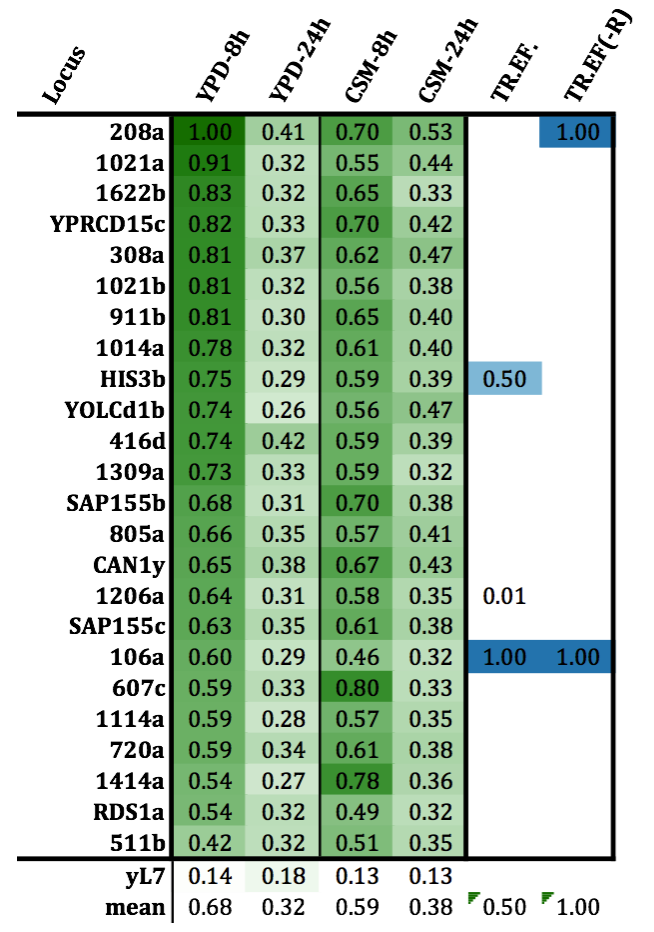

WHICH CUT SITE DO YOU WANT from the above list? e.g., "208a":208a




What do you want to do to 208a?

	1	 You have a CDS but want help picking promoter and terminator

	2	 You already have a one-piece cassette and just want to integrate it


Your answer: 1


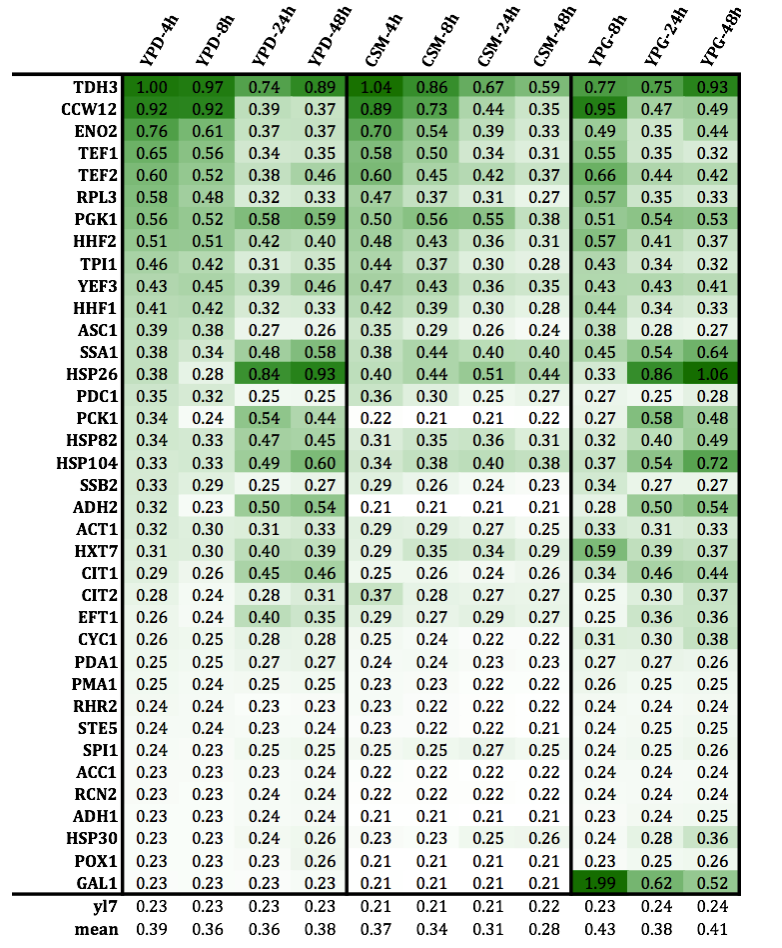

Which PROMOTER do you want to use, e.g., "TDH3": HSP26




Which TERMINATOR do you want to use, e.g., "ADH1": ADH1




What is the name of your CDS, e.g., "KlGapDH": TXS




What's the sequence: ATGGACAAGAAGTACTCTATCGGCCTGGACATCGGCACCAACTCTGTGGGCTGGGCCGTGATCACCGACGAGTACAAGGTGCCCTCTAAGAAGTTCAAGGTGCTGGGCAACACCGACCGACACTCTATCAAGAAGAACCTGATCGGCGCCCTGCTGTTCGACTCTGGCGAGACCGCCGAGGCCACCCGACTGAAGCGAACCGCCCGACGACGATACACCCGACGAAAGAACCGAATCTGCTACCTGCAGGAGATCTTCTCTAACGAGATGGCCAAGGTGGACGACTCTTTCTTCCACCGACTGGAGGAGTCTTTCCTGGTGGAGGAGGACAAGAAGCACGAGCGACACCCCATCTTCGGCAACATCGTGGACGAGGTGGCCTACCACGAGAAGTACCCCACCATCTACCACCTGCGAAAGAAGCTGGTGGACTCTACCGACAAGGCCGACCTGCGACTGATCTACCTGGCCCTGGCCCACATGATCAAGTTCCGAGGCCACTTCCTGATCGAGGGCGACCTGAACCCCGACAACTCTGACGTGGACAAGCTGTTCATCCAGCTGGTGCAGACCTACAACCAGCTGTTCGAGGAGAACCCCATCAACGCCTCTGGCGTGGACGCCAAGGCCATCCTGTCTGCCCGACTGTCTAAGTCTCGACGACTGGAGAACCTGATCGCCCAGCTGCCCGGCGAGAAGAAGAACGGCCTGTTCGGCAACCTGATCGCCCTGTCTCTGGGCCTGACCCCCAACTTCAAGTCTAACTTCGACCTGGCCGAGGACGCCAAGCTGCAGCTGTCTAAGG

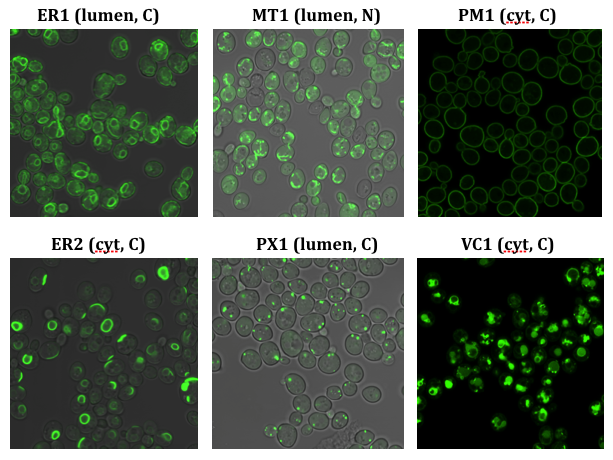














Here are the primers to amplify your fragments and construct your donor DNA cassette:

Fup208a TTTTTTCTGATTGCTCTATACTCAAACCAAC
Rup208a(HSP26ps) GAATTGTGGCTTACTGTAAGCTAGTGTGTATGGTCCCTATTGGCAC
FHSP26ps(up208a) GAGTCGGTGCCAATAGGGACCATACACACTAGCTTACAGTAAGCCACAATTCTCTTAC
RHSP26ps(TXS) GGCCGATAGAGTACTTCTTGTCCATGTTAATTTGTTTAGTTTGTTTGTTTGCTTTTTTGG
FTXS(HSP26ps) AAACAAACAAACTAAACAAATTAACATGGACAAGAAGTACTCTATCGGCC
RTXS(ADH1ts) ATAAATCATAAGAAATTCGCCAGCTTTCGAGACAGTCGGC
FADH1ts(TXS) GAAAGCTGGCGAATTTCTTATGATTTATGATTTTTATTATTAAATAAGTTATAAAAAAAA
RADH1ts(dn208a) TTAACTATAAAGCACATAAACTACAAGTGGAGTTAGCATATCTACAATTGGGTGAA
Fdn208a(ADH1ts) ACCCAATTGTAGATATGCTAACTCCACTTGTAGTTTATGTGCTTTATAGTTAATGATCAC
Rdn208a AGTGTCTTAAATGCGAAGAAGGTATGG


The size and sequence of your donor DNA is below.
4848
TTTTTTCTGATTGCTCTATACTCAAACCAACAACAACTTACTCTACAACTAATGTCCTCTGCCGCCGAAAAGAAACCAGCTTCCAAAGCTCCAGCTGAAAAGAAGCCAGCTGCCAAGAAAACATCAACCTCCGTCGATGGTAAGAAGAGATCTAAGGTTAGAAAGGAGACCTATTCCTCTTATATTTACAAAGTTTTGAAGCAAACTCA

"\nHold on a moment, it's working... \nThe interface should appear below momentarily.\n\n\n\n\n\n\n\n\n\n\n\n"

In [3]:
'''
CLICK HERE 



































'''


# import libraries we're using

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio.SeqUtils import MeltingTemp
import copy
from intermine.webservice import Service
from pandas import *
from pandas import DataFrame, read_csv
import pandas as pd  
import matplotlib.pyplot as plt
import sys
from IPython.display import Image
from IPython.display import display
%matplotlib inline 



# define global variables
HomologyLength = 1000
PrimerMaxTm = 55 # As calculated by statluc, more like 65C by Thermo's Phusion program
PrimerMaxLen = 60
OverhangMaxFrac = 1



def askUser():
    print('Python version ' + sys.version+"\n\n\n\n")
    print("\nHi, welcome to CASdesigner.\n")

          
    print("Refer to this community google doc for documentation and feedback:")
    print("https://docs.google.com/document/d/11YNoUBtit4rkWZQr_ZclzAOTE_HGMtgB3H_6cvq1Y24/edit?usp=sharing")
    print("\n\n\n\nWHAT DO YOU WANT TO DO TO S288C? Type \"1\", \"2\", or \"3\".\n")
    print("\t 1 \t add to empty (insert DNA into a well-characterized site)\n") 
    print("\t 2 \t edit existing (delete or replace a gene of interest)\n")
    print("\t 3 \t stitch (get primers to stich together N fragments)\n")

   
    Action= input("Your answer: ")
    if Action == "1":
        editEmpty()
        
    elif Action == "2":
        editExisting()

    elif Action == "3": # This is more for stitching things together not necessarily for CRISPR
        buildCustom()
             
            
            
def editEmpty():    
    
    # I have an excel file where we keep cut site information
    # and load it as a pandas dataframe called cutFrame
    
    cutFrame = pd.read_excel("locusTable.xlsx", index_col="cutName")
    
    #print(cutFrame)
    
    
    LocusPic=Image("LocusLevelExp.png")
    display(LocusPic)
    
    
    cutName=input("WHICH CUT SITE DO YOU WANT from the above list? e.g., \"208a\":")

    # cutName is a string that should correspond to one of the variables
    # of the "cutName" column in dataFrame, e.g., 208a
    
    # cutFrame has the 20nt sequence of the gRNA saved, which we load
    # It also has some more information we'll get to later
    cutSequence=cutFrame.loc[cutName,'cutSequence']

    # We need to load the chromosome where the cut site is
    location=cutFrame.loc[cutName,'cutChr']+".fasta"
     
    ChromosomeSeq=SeqIO.read(location, "fasta").seq
    
    if ChromosomeSeq.find(cutSequence)==-1:
        ChromosomeSeq=ChromosomeSeq.reverse_complement()
        if ChromosomeSeq.find(cutSequence)==-1:
            print("CAN'T FIND THE CUT SITE IN YOUR SEQUENCE")

    StartIndex=ChromosomeSeq.find(cutSequence)
    EndIndex=StartIndex+34
    
    UpSeq=ChromosomeSeq[StartIndex-HomologyLength:StartIndex]
    DownSeq=ChromosomeSeq[EndIndex:EndIndex+HomologyLength]
        
    UpHomRec = SeqRecord(UpSeq, name="up"+cutName)
    DownHomRec = SeqRecord(DownSeq, name="dn"+cutName)
    
    print("\n\n\n\nWhat do you want to do to " + cutName + "?\n")
    print("\t1\t You have a CDS but want help picking promoter and terminator\n")
    print("\t2\t You already have a one-piece cassette and just want to integrate it\n\n")
    # Coming later
    # print("\t3\t You want to construct a donor containing two standard cassettes (pointing away from each other\n")

    typeEdit=input("Your answer: ")
    if typeEdit=="1":
    
        PromoterRec, orfRecord, TerminatorRec = buildCassette()
        
        fragments=[UpHomRec, PromoterRec, orfRecord, TerminatorRec, DownHomRec]

    
    elif typeEdit == "2":
        
        orfName=input("What's the name of your custom gene or cassette?")
        orfSeq=Seq(input("What's the sequence? "))
        orfRecord=SeqRecord(orfSeq,name=orfName)
        
        fragments=[UpHomRec, orfRecord, DownHomRec]

    elif typeEdit == "3":
        
        print("Your construct will look like this: ")
        print("up hom-<terminator1-gene1-promoter1<->promoter2-gene2-terminator2>-downhom")
        print("OK, let's build your FIRST cassette")
        PromoterRec1, orfRecord1, TerminatorRec1 = buildCassette()
         
        #now in the construction, these will be in the antisense direction, so let's change their sequences
        rTerminatorRec1=flipRecord(TerminatorRec1)
        rorfRecord1=flipRecord(orfRecord1)
        rPromoterRec1=flipRecord(PromoterRec1)
        
        print("OK, let's build your SECOND cassette")
        PromoterRec2, orfRecord2, TerminatorRec2 = buildCassette()

        fragments=[UpHomRec, rTerminatorRec1, rorfRecord1, rPromoterRec1,PromoterRec2,orfRecord2, TerminatorRec2,DownHomRec]

    print("\n\n\n\n\n\n\n\n")
    stitch(fragments)
    
    
    
def editExisting():
    
    print(" ")
    print("WHICH GENE DO YOU WANT TO EDIT? Tell me a common name, e.g., \"OAF1\"")
    print("I'm smart and pretty and I can fetch it for you.\n")
    
    GeneName= input("Your answer: ")
    
    OrigGeneRecord=fetchGene(GeneName)
    # note that this returns a seqrecord
    
    print("\n"+GeneName+" is "+OrigGeneRecord.features+", which encodes "+OrigGeneRecord.description+", Bold choice.")

    
    # We make seqrecords since that's what we carry through later in the program

    UpHomRec = fetchNeighbor(OrigGeneRecord, "upstream", HomologyLength )
    UpHomRec.name="up"+UpHomRec.name 
    DownHomRec = fetchNeighbor(OrigGeneRecord, "downstream", HomologyLength )
    DownHomRec.name="down"+DownHomRec.name 

    print("\n\n\n\nWHAT DO YOU WANT TO DO TO " + GeneName + "?\n")
    print("\t1\t DELETE the CDS cleanly--from start to stop codon\n")
    print("\t2\t replace the CDS with another CDS\n")
    print("\t3\t replace the CDS with an expression cassette I will help you build\n")
    print("\t4\t replace a specified region near your target gene with another specified region\n")
    
    typeEdit=input("Your answer: ")
    
    # Now let's pick the cut site. This is independent from the donor cassette
    # We have an excel sheet with genes and pre-picked cut sites
    # Or let the user pick
    
    print("\n\n\n\nHave you heard of CRISPR? We will need a guideRNA. In the future I will help you pick it.")
    cutChoice=input("Please enter your 20-nt gRNA here.\n")
    
    
    if cutChoice=="p":
        cutSequence=cutFinder(GeneName)
    elif len(cutChoice)==20:
        cutSequence=cutChoice
        # Later should check that the sequence is present and unique
    
   
    
    #note that in all the below, we want to have fragments be records
    if typeEdit=="1":
        fragments=[UpHomRec,DownHomRec]
    
    if typeEdit=="3":
        PromoterRec, orfRecord, TerminatorRec = buildCassette()
        fragments=[UpHomRec, PromoterRec, orfRecord, TerminatorRec, DownHomRec] #we need to finish buildcassette to add InsertRec here

    if typeEdit=="2":
        print(" ")
        NewGeneName=input("\n\n\n\nWhat's the name of the gene you're inserting?")
        NewGeneSeq=Seq(input("\n\n\n\nWhat's the sequence of your new gene? "))
        InsertRec = SeqRecord(NewGeneSeq, name=NewGeneName)
        fragments=[UpHomRec, InsertRec, DownHomRec]

    if typeEdit=="4":
        print("How many pieces (other than homology fragments) are you stitching together.")
        Npieces=input("Your answer: ")
        output = buildCassette()

        fragments=[UpHomRec, DownHomRec] #we need to finish buildcassette to add InsertRec here

    
    print("\n\n\n\n\n\n\n\nHere is the oligo to clone or gap-repair your cut plasmid:\n")
    print("cut"+GeneName+" tggcgaatgggacttt"+cutSequence+"gttttagagctagaaatagcaagt\n")

    # Now we feed the design to a tool to pick primers which amplify each fragment
    # and add terminal homology to the neighboring fragments
    
    
    stitch(fragments)

    
    
def buildCustom():
    N = int(input("How many pieces in your custom cassette: "))
    fragments = variableCassette(N)[0]
    stitch(fragments)

            
    #------------------------------ FETCH FUNCTIONS -------------------------------------

    
def fetchGene(GeneName):
    
    service = Service("http://yeastmine.yeastgenome.org/yeastmine/service")
    template = service.get_template('Gene_GenomicDNA')

    rows = template.rows(
        E = {"op": "LOOKUP", "value": GeneName, "extra_value": "S. cerevisiae"}
    )
    
    # this service seems to return multiple similar genes but we want the first one only, so count
    # and it returns information about the gene you want
    count=0
    for row in rows:
        
        count=count+1
        if count==1:
            descr= row["description"]
            GeneSeq=Seq(row["sequence.residues"])
            GeneSysName=row["secondaryIdentifier"]
       
    #let's create a record for the oldGene
    GeneRecord = SeqRecord(GeneSeq, id=GeneSysName)
    
    #now let's add some more information to make it useful
    GeneRecord.name=GeneName
    GeneRecord.features=GeneSysName
    GeneRecord.description=descr

    return GeneRecord 
       
    
    
def fetchNeighbor(NeighborRecord, direction, distance):

    # let's load the appropriate chromosome file. The record of the gene we looked up
    # contains in the "features" the systematic name, wherein the second letter
    # corresponds to chromosome number, e.g., 1=A etc
    if NeighborRecord.features[1]=="A":
        ChromosomeRec=SeqIO.read("Scer01.fasta", "fasta")
    if NeighborRecord.features[1]=="B":
        ChromosomeRec=SeqIO.read("Scer02.fasta", "fasta")
    if NeighborRecord.features[1]=="C":
        ChromosomeRec=SeqIO.read("Scer03.fasta", "fasta")
    if NeighborRecord.features[1]=="D":
        ChromosomeRec=SeqIO.read("Scer04.fasta", "fasta")
    if NeighborRecord.features[1]=="E":
        ChromosomeRec=SeqIO.read("Scer05.fasta", "fasta")
    if NeighborRecord.features[1]=="F":
        ChromosomeRec=SeqIO.read("Scer06.fasta", "fasta")
    if NeighborRecord.features[1]=="G":
        ChromosomeRec=SeqIO.read("Scer07.fasta", "fasta")
    if NeighborRecord.features[1]=="H":
        ChromosomeRec=SeqIO.read("Scer08.fasta", "fasta")
    if NeighborRecord.features[1]=="I":
        ChromosomeRec=SeqIO.read("Scer09.fasta", "fasta")
    if NeighborRecord.features[1]=="J":
        ChromosomeRec=SeqIO.read("Scer10.fasta", "fasta")
    if NeighborRecord.features[1]=="K":
        ChromosomeRec=SeqIO.read("Scer11.fasta", "fasta")
    if NeighborRecord.features[1]=="L":
        ChromosomeRec=SeqIO.read("Scer12.fasta", "fasta")
    if NeighborRecord.features[1]=="M":
        ChromosomeRec=SeqIO.read("Scer13.fasta", "fasta")
    if NeighborRecord.features[1]=="N":
        ChromosomeRec=SeqIO.read("Scer14.fasta", "fasta")
    if NeighborRecord.features[1]=="O":
        ChromosomeRec=SeqIO.read("Scer15.fasta", "fasta")
    if NeighborRecord.features[1]=="P":
        ChromosomeRec=SeqIO.read("Scer16.fasta", "fasta") 

    
    
    # let's explicitely name the sequences from the seq record
    NeighborSeq=NeighborRecord.seq
    ChromosomeSeq=ChromosomeRec.seq
    
    # flip the sequence to orient with respect to the old gene
    if ChromosomeSeq.find(NeighborSeq)==-1:
        ChromosomeSeq=ChromosomeSeq.reverse_complement()

    StartIndex=ChromosomeSeq.find(NeighborSeq)
    EndIndex=StartIndex+len(NeighborSeq)
    
    if direction=="upstream":
        DesiredSeq=ChromosomeSeq[StartIndex-distance:StartIndex]
    if direction=="downstream":
        DesiredSeq=ChromosomeSeq[EndIndex:EndIndex+distance]

    
    
    
    NeighborRec = SeqRecord(DesiredSeq, name=NeighborRecord.name)
    
    return NeighborRec


    
    
    
    #------------------------------------ CONSTRUCTING STUFF --------------------------------------

def getPrimer(currRecord):
    

    mp = 0
    length = 0
    primer = Seq("")

    seq=currRecord.seq
    
    while mp <= PrimerMaxTm and length <= PrimerMaxLen:
        primer = primer + seq[length]
        mp = MeltingTemp.Tm_staluc(primer)
        length += 1

    return primer           
        
def overhangPrimer(currRecord,prevSeq):
    #let's get the template-binding primer first
    primer=getPrimer(currRecord)
    
    
    #OK let's work on the overhang
    maxOhLen=PrimerMaxLen-len(primer)    
    maxFrac=1
    
    #let's decide on a max overhang length
    if round(len(primer)*(OverhangMaxFrac+1)) < 60:
             maxOhLen=round(len(primer)*OverhangMaxFrac)
    
    #the index must be an integer!!!
    maxOhLen=int(maxOhLen)
    ohprimer=prevSeq.seq[-maxOhLen:]+primer #we add the .seq so that it returns a string
    
    return ohprimer      
        

          
def buildCassette():
    
    # Let's display data
    PromPic=Image("PromoterLevelExp.png")
    display(PromPic) 
       
    PromoterName=input("Which PROMOTER do you want to use, e.g., \"TDH3\": ")
    PromoterGeneRec=fetchGene(PromoterName)
    PromoterRec=fetchNeighbor(PromoterGeneRec,"upstream",600)
    PromoterRec.name=PromoterRec.name+"ps"
    
    
    #second, the terminator
    TerminatorName = input("\n\n\n\nWhich TERMINATOR do you want to use, e.g., \"ADH1\": ")
    TerminatorGeneRec=fetchGene(TerminatorName)
    TerminatorRec=fetchNeighbor(TerminatorGeneRec,"downstream",250)
    TerminatorRec.name=TerminatorRec.name+"ts"
    
    #and last, the gene
    orfName = input("\n\n\n\nWhat is the name of your CDS, e.g., \"KlGapDH\": ")
    
    orfSeq=input("\n\n\n\nWhat's the sequence: ")
    
    
    print("\n\n\n\nWe have a couple of protein tags we can show you how to add.")
    print("Ask one of us if you're interested in this type of stuff.")
    LocTags=Image("LocTags.png")
    display(LocTags)
    
    
    orfRecord=SeqRecord(Seq(orfSeq), name=orfName)
    
    #print("\nDo you want to attach any protein tags?\n")
    #print("This is under construction but here is tag CNE1 targeting to the ER lumen.\n")
    #CNE1tag=Image("CNE1tag.png")
    #display(CNE1tag)
    
    insertRec=[PromoterRec,orfRecord,TerminatorRec]
    return PromoterRec, orfRecord, TerminatorRec
    

    

def variableCassette(N, toVary = 0, variants = 0):
    print("")
    print("Let's start building.")
    print("")
    
    # Store both name and sequence in a SeqRecord
    # Append them to a list
    # Return list as fragments to be stitched

    records = []
    for n in range(N):
        name = input("What is the name of sequence " + str(n+1) +":")
        sequence = input("What is the sequence of this fragment:\n")
        Rec = SeqRecord(Seq(sequence), id = str(n+1))
        Rec.name = name
        records.append(Rec)

    variantRecords = []
    variantRecords.append(records)
    # This only happens if there are variants.
    if variants > 0:
        print("Time to make those variants you wanted.")
        for n in range(variants-1):
            name = input("What is the name of variant " + str(n+1) + ":")
            sequence = input("What is the sequence of this variant:")
            Rec = SeqRecord(Seq(sequence), id = str(n+1))
            Rec.name = name
            # Make a copy of the original, switch the fragments and add it to the list. 
            # Deep-copy ensures there are no pointer issues
            tempVariant = copy.deepcopy(records)
            tempVariant[toVary - 1] = Rec
            variantRecords.append(copy.deepcopy(tempVariant))
 
    # Returns a list of lists of the SeqRecords of the fragments
    return variantRecords


def stitch(fragments):
    #this function takes seq records and prints primers
    
    #let's make an empty sequence file
    Nfrags=len(fragments)
    donor=Seq("")
    index=[]

    print("\n\n\n\nHere are the primers to amplify your fragments and construct your donor DNA cassette:\n")

    for i in range (0, Nfrags):
        donor=donor+fragments[i]
    
    # The names include information on the homology provided by the overhang
    # Note that some primers don't have overhangs
    for i in range (0, Nfrags):
        if i==0:
            print("F"+ fragments[i].name + " " + getPrimer(donor))
            print("R"+ fragments[i].name + "(" + fragments[i+1].name + ") " + overhangPrimer(fragments[i].reverse_complement(),fragments[i+1].reverse_complement()))
        elif i==Nfrags-1:
            print("F"+ fragments[i].name + "(" + fragments[i-1].name + ") " + overhangPrimer(fragments[i],fragments[i-1]))
            print("R"+ fragments[i].name + " " + getPrimer(donor.reverse_complement()))
        else:
            print("F"+ fragments[i].name + "(" + fragments[i-1].name + ") " + overhangPrimer(fragments[i],fragments[i-1]))
            print("R"+ fragments[i].name + "(" + fragments[i+1].name + ") " + overhangPrimer(fragments[i].reverse_complement(),fragments[i+1].reverse_complement()))

    print("\n\nThe size and sequence of your donor DNA is below.")

    print(len(donor.seq))

    print(donor.seq)

    print("\n\n\n\nGOOD LUCK! Refer to the this link for user guide, feedback, and community tips.")
    print("https://docs.google.com/document/d/11YNoUBtit4rkWZQr_ZclzAOTE_HGMtgB3H_6cvq1Y24/edit?usp=sharing\n")
    
        
def flipRecord(origRecord):
    origRecord.seq=origRecord.seq.reverse_complement()
    origRecord.name="r"+origRecord.name
    return origRecord
    
def cutFinder(GeneName):
    cutFrame = pd.read_excel("cutsTable.xlsx", index_col="cutName")
    
    # cutFrame has the 20nt sequence of the gRNA saved, which we load
    # It also has some more information we'll get to later
    
    cutSequence=cutFrame.loc[GeneName,'cutSequence']
    
    print("\nI picked the following cut site for you "+cutSequence)
    
    return cutSequence


askUser()






















'''
Hold on a moment, it's working... 
The interface should appear below momentarily.











'''